# Week 1: Python Business Analytics

# Bike Sharing 

This notebook documents the analysis and model development for the Bike Sharing Dataset. It contains the following steps:

- About the Bike Sharing Dataset
- Descriptive Analysis
- Missing Value Analysis
- Outlier Analysis
- Correlation Analysis
- Overview metrics
- Model Selection
    -  Ridge Regession
    - Support Vector Regression
    - Essemble Regressor
    - Random Forest Regressor
- Random Forest
    - Random Forest Model
    - Feature importance
- Conclusion
- Future Work

## About the Bike Sharing Dataset

### Overview

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return back has become automatic. Through these systems, the user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure, and arrival position is explicitly recorded in these systems. This feature turns the bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of the important events in the city could be detected via monitoring these data.

### Attribute Information

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not 
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    

- temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import numpy as np
# Sklearn model delection
from sklearn.model_selection import RandomizedSearchCV
# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression

import random

%matplotlib inline

# Make results reproducible
random.seed(100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd


class Dataloader(): 
    '''Bike Sharing Dataset dataloader.    
    '''

    def __init__(self, csv_path):
        ''' Initialize Bike Sharing Dataset dataloader.
        
        Arguments:
            csv_path {str} -- Path to the Bike Sharing Dataset CSV file.
        '''

        self.csv_path = csv_path
        self.data = pd.read_csv(self.csv_path)

        # Shuffle
        self.data.sample(frac=1.0, replace=True, random_state=1)

    def getHeader(self):
        ''' Get the column names of the Bike Sharing CSV file.
        
        Returns:
            [list of str] -- the column names of the csv file
        '''

        return list(self.data.columns.values)

    def getData(self):
        ''' Get the pandas frames for the training, validation and test split
        
        Returns:
            [pandas frames] -- the pandas frames for the different splits
        '''

        # Split data into train, validation and test set with 60:20:20 ratio
        split_train = int(60 / 100 * len(self.data)) 
        split_val = int(80 / 100 * len(self.data)) 
        train = self.data[:split_train]
        val = self.data[split_train:split_val]
        test = self.data[split_val:]
        return train, val,  test

    def getFullData(self):
        ''' Get all the data in one single pandas frame.
        
        Returns:
            [pandas frame] -- the complete Bike Sharing Dataset data
        '''

        return self.data

## Descriptive Analysis

Provide data set splits for training, validation, and testing:

In [4]:
dataloader = Dataloader('hour.csv')


In [5]:
train, val, test = dataloader.getData()
fullData = dataloader.getFullData()

category_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']

features= category_features + number_features
target = ['cnt']

Get column names of the pandas data frame:

In [6]:
print(list(fullData.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


Print the first two samples of the dataset to explore the data:

In [7]:
print(fullData.head(2))

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  


Get data statistics for each column:

In [8]:
print(fullData[number_features].describe())

               temp         atemp           hum     windspeed
count  17379.000000  17379.000000  17379.000000  17379.000000
mean       0.496987      0.475775      0.627229      0.190098
std        0.192556      0.171850      0.192930      0.122340
min        0.020000      0.000000      0.000000      0.000000
25%        0.340000      0.333300      0.480000      0.104500
50%        0.500000      0.484800      0.630000      0.194000
75%        0.660000      0.621200      0.780000      0.253700
max        1.000000      1.000000      1.000000      0.850700


In [9]:
for col in category_features:
    fullData[col] = fullData[col].astype('category')
print(fullData[category_features].describe())

        season  holiday   mnth     hr  weekday  workingday  weathersit
count    17379    17379  17379  17379    17379       17379       17379
unique       4        2     12     24        7           2           4
top          3        0      7     17        6           1           1
freq      4496    16879   1488    730     2512       11865       11413


## Missing Value Analysis

Check any NULL values in data:

In [10]:
print(fullData.isnull().any())

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool


## Outlier Analysis

### Box plots

[Text(0.5, 0, 'Temperature'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

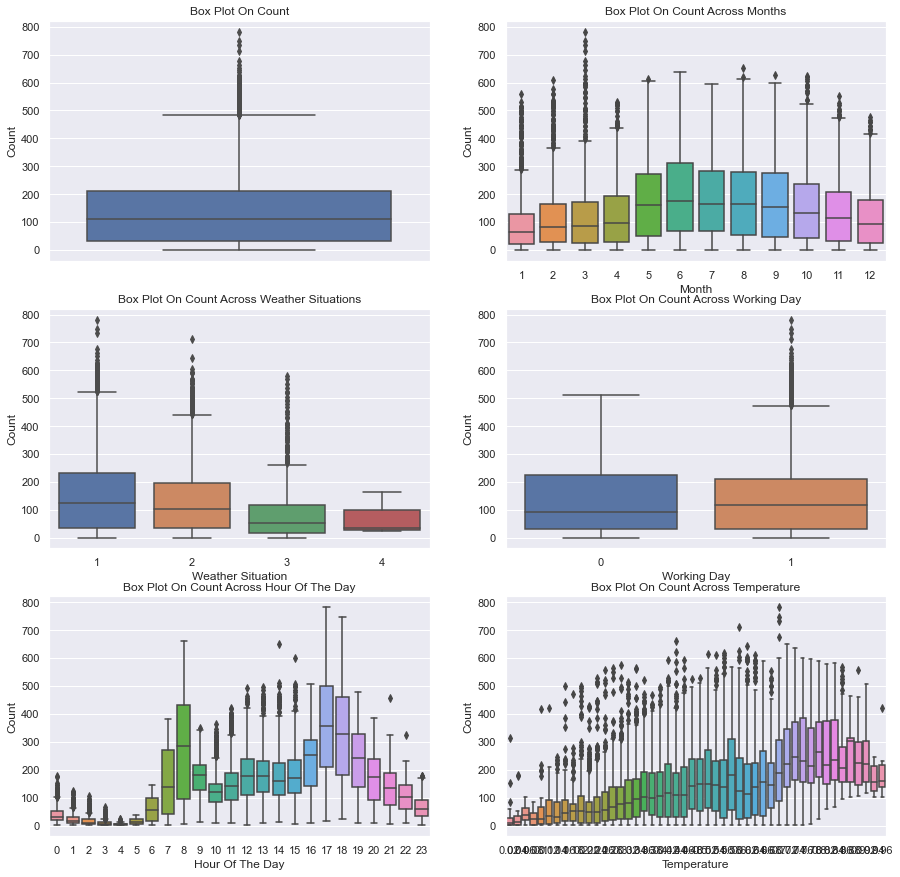

In [11]:
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=train,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="cnt",x="hr",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="cnt",x="temp",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")


__Interpretation:__ The working day and holiday box plots indicate that more bicycles are rent during normal working days than on weekends or holidays. The hourly box plots show a local maximum at 8 am and one at 5 pm which indicates that most users of the bicycle rental service use the bikes to get to work or school. Another important factor seems to be the temperature: higher temperatures lead to an increasing number of bike rents and lower temperatures not only decrease the average number of rents but also shows more outliers in the data.

### Remove outliers from data

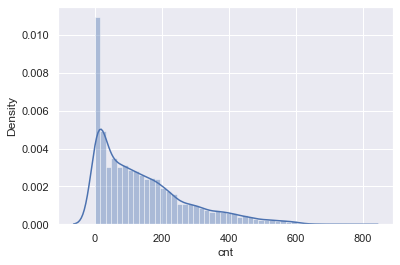

In [14]:
sns.distplot(train[target[-1]]);

The distribution plot of the count values reveals that the count values do not match a normal distribution. We will use the median and interquartile range (IQR) to identify and remove outliers from the data. (An alternative approach would be the transformation of the target values to a normal distribution and using mean and standard deviation.)  

Samples in train set with outliers: 10427
Samples in train set without outliers: 10151


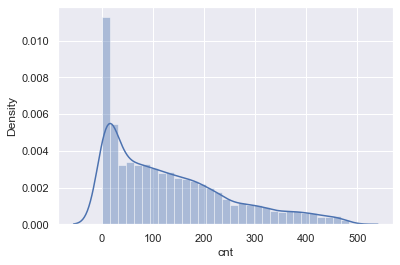

In [15]:
print("Samples in train set with outliers: {}".format(len(train)))
q1 = train.cnt.quantile(0.25)
q3 = train.cnt.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
train_preprocessed = train.loc[(train.cnt >= lower_bound) & (train.cnt <= upper_bound)]
print("Samples in train set without outliers: {}".format(len(train_preprocessed)))
sns.distplot(train_preprocessed.cnt);

## Correlation Analysis

<AxesSubplot:>

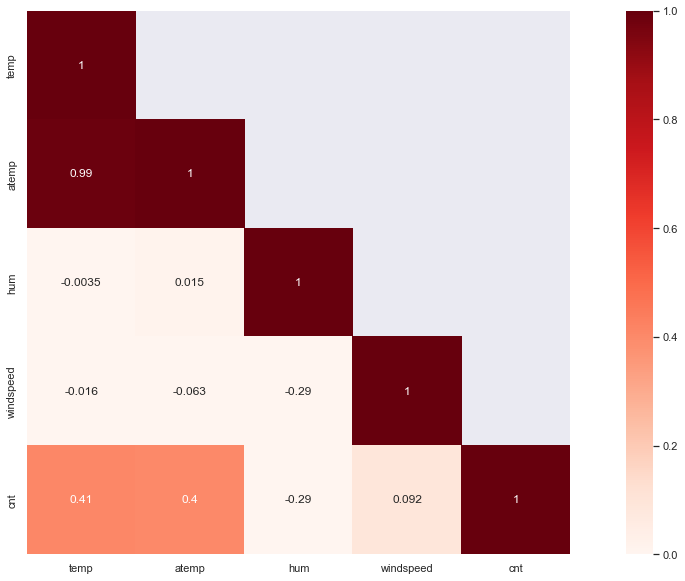

In [16]:
matrix = train[number_features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

__Conclusion:__ At the end of the descriptive analysis chapter, we can note the following points:

- Casual and registered contain direct information about the bike sharing count which is to predict (data leakage). Therefore they are not considered in the feature set.
- The variables "temp" and "atemp" are strongly correlated. To reduce the dimensionality of the predictive model, the feature "atemp" is dismissed.
- The variables "hr" and "temp" seem to be promising features for the bike sharing count prediction.


In [17]:
features.remove('atemp')

## Overview Metrics

### Mean Squared Error (MSE)

MSE = $\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

### Root Mean Squared Logarithmic Error (RMSLE)

RMSLE = $\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(x_i) - \log(y_i))^2 }$

### $R^2$ Score

$R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$

## Model Selection

The characteristics of the given problem are:

- __Regression:__ The target variable is a quantity.
- __Small dataset:__ Less than 100K samples.
- __Few features should be important:__ The correlation matrix indicates that a few features contain the information to predict the target variable.

This characteristic makes the following methods most promising: Ridge Regression, Support Vector Regression, Ensemble Regressor, Random Forest Regressor.

We will evaluate the performance of these models in the following:

In [18]:
x_train = train_preprocessed[features].values
y_train = train_preprocessed[target].values.ravel()
# Sort validation set for plots
val = val.sort_values(by=target)
x_val = val[features].values
y_val = val[target].values.ravel()
x_test = test[features].values

table = PrettyTable()
table.field_names = ["Model", "Mean Squared Error", "R² score"]

models = [
    SGDRegressor(max_iter=1000, tol=1e-3),
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    Ridge(alpha=.5),
    SVR(gamma='auto', kernel='linear'),
    SVR(gamma='auto', kernel='rbf'),
    BaggingRegressor(),
    BaggingRegressor(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    NuSVR(gamma='auto'),
    RandomForestRegressor( random_state=0, n_estimators=300)
]

for model in models:
    model.fit(x_train, y_train) 
    y_res = model.predict(x_val)

    mse = mean_squared_error(y_val, y_res)
    score = model.score(x_val, y_val)    

    table.add_row([type(model).__name__, format(mse, '.2f'), format(score, '.2f')])

print(table)

+-----------------------+--------------------+----------+
|         Model         | Mean Squared Error | R² score |
+-----------------------+--------------------+----------+
|      SGDRegressor     |      36444.48      |   0.22   |
|         Lasso         |      43103.36      |   0.07   |
|       ElasticNet      |      54155.92      |  -0.17   |
|         Ridge         |      42963.88      |   0.07   |
|          SVR          |      50794.62      |  -0.09   |
|          SVR          |      41659.68      |   0.10   |
|    BaggingRegressor   |      19467.43      |   0.58   |
|    BaggingRegressor   |      45641.51      |   0.02   |
|         NuSVR         |      41517.67      |   0.11   |
| RandomForestRegressor |      18949.93      |   0.59   |
+-----------------------+--------------------+----------+


## Random Forest

### Random Forest Model

In [19]:
# Table setup
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MSE", "MAE", 'RMSLE', "R² score"]
# Model training
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model.fit(x_train, y_train) 

def evaluate(x, y, dataset):
    pred = model.predict(x)

    mse = mean_squared_error(y, pred)
    mae = mean_absolute_error(y, pred)
    score = model.score(x, y)    
    rmsle = np.sqrt(mean_squared_log_error(y, pred))

    table.add_row([type(model).__name__, dataset, format(mse, '.2f'), format(mae, '.2f'), format(rmsle, '.2f'), format(score, '.2f')])
    

evaluate(x_train, y_train, 'training')
evaluate(x_val, y_val, 'validation')

print(table)

+-----------------------+------------+----------+-------+-------+----------+
|         Model         |  Dataset   |   MSE    |  MAE  | RMSLE | R² score |
+-----------------------+------------+----------+-------+-------+----------+
| RandomForestRegressor |  training  |  297.36  | 10.90 |  0.21 |   0.98   |
| RandomForestRegressor | validation | 18955.36 | 96.47 |  0.48 |   0.59   |
+-----------------------+------------+----------+-------+-------+----------+


### Feature importance

In [20]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [21]:
# Print the feature ranking
print("Feature ranking:")

for f in range(x_val.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature hr (0.634805)
2. feature temp (0.159158)
3. feature hum (0.049517)
4. feature workingday (0.046949)
5. feature weathersit (0.026713)
6. feature windspeed (0.026487)
7. feature weekday (0.020271)
8. feature mnth (0.020078)
9. feature season (0.013001)
10. feature holiday (0.003020)


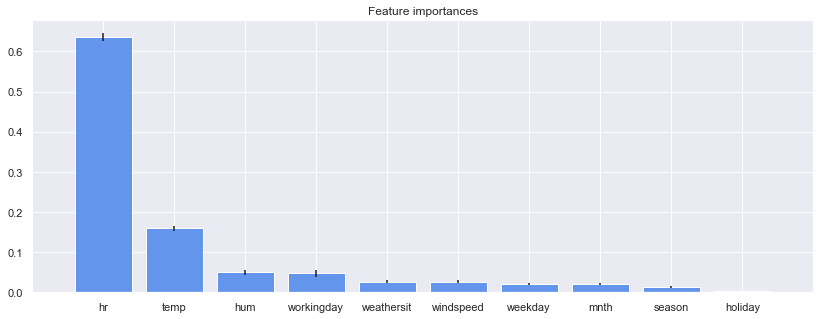

In [22]:
# Plot the feature importances of the forest
plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(x_val.shape[1]), importances[indices], color="cornflowerblue", yerr=std[indices], align="center")
plt.xticks(range(x_val.shape[1]), [features[i] for i in indices])
plt.xlim([-1, x_val.shape[1]])
plt.show()

__Interpretation:__ The result corresponds to the high correlation of the hour and temperature variable with the bicycle sharing count in the feature correlation matrix.